<a href="https://colab.research.google.com/github/lmichan/BIOliteraturaPE203625/blob/main/Enlace_con_Zotero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de la Biblioteca Zotero - Biología 2025

Este cuaderno de Google Colab fue desarrollado por José Antonio Hernández Mondragón como parte del proyecto PAPIME PE203625.

El propósito principal de este código es realizar un análisis detallado de la biblioteca Zotero correspondiente al curso de Biología 2025, con el fin de extraer información relevante, identificar patrones de uso, temáticas predominantes y apoyar la toma de decisiones en la gestión y mejora de los recursos bibliográficos disponibles.

A lo largo del cuaderno se implementan herramientas de procesamiento de datos, visualización y análisis bibliométrico para obtener una visión integral del contenido y estructura de la biblioteca Zotero.

## Conexión entre Zotero y Google Colab

Para realizar el análisis de la biblioteca de Zotero desde Google Colab, es necesario establecer una conexión entre ambas plataformas utilizando la Zotero Web API. Esta API permite acceder a colecciones, referencias, metadatos y otros recursos almacenados en una cuenta o grupo de Zotero, lo cual facilita el procesamiento automatizado de los datos.

## Requisitos de configuración

Antes de comenzar el análisis, es necesario contar con dos elementos clave:

* Zotero API Key

* Group ID (en caso de trabajar con una biblioteca de grupo)

### 1. Zotero API Key

La API Key es una clave personal que otorga permisos para acceder a la biblioteca Zotero de forma segura. Para obtenerla, sigue estos pasos:

* Accede a tu cuenta en Zotero.org.

* Ve a Settings > Feeds/API.

* En la sección de API Keys, haz clic en Create new private key.

* Define los permisos de acceso (por ejemplo, lectura) y copia la clave generada.

* Esta clave se utilizará en el código para autenticar las solicitudes a la API.

### 2. Group ID

Si estás trabajando con una biblioteca de grupo, también necesitas el identificador único del grupo. Para obtenerlo:

* Ingresa al sitio de Zotero y selecciona tu grupo.

* El Group ID se encuentra en la URL del grupo. Por ejemplo, en: https://www.zotero.org/groups/1234567/nombre_del_grupo

* El número 1234567 es el Group ID que deberás usar.


In [7]:
# CONFIGURA TU CLAVE Y GROUP ID

import requests
from collections import defaultdict, Counter
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import random

# Si es necesario se instala la libreria.
# !pip install wordcloud matplotlib
# !pip install pyspellchecker

# CONFIGURA TU CLAVE Y GROUP ID (Estos se obtienen en Zotero)
API_KEY = "l7nkDwrKLxASVprKSjbadbXs"
GROUP_ID = "5866354"
HEADERS = {"Zotero-API-Key": API_KEY}


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 63.5 MB/s eta 0:00:00


In [8]:
# Descargar ítems (paginado si es necesario)
items = []
all_tags = []
start = 0
limit = 100

while True:
    url = f"https://api.zotero.org/groups/{GROUP_ID}/items?limit={limit}&start={start}"
    response = requests.get(url, headers=HEADERS)

    if response.status_code != 200:
        print(f"Error al obtener datos: {response.status_code}")
        break

    data = response.json()
    if not data:
        break

    for item in data:
        if "data" in item:
            item_data = item["data"]
            tags = [tag["tag"] for tag in item_data.get("tags", [])]
            all_tags.extend(tags)  # Agregamos las etiquetas a una lista general

            items.append({
                "titulo": item_data.get("title"),
                "fecha": item_data.get("dateAdded"),
                "etiquetas": tags
            })

    start += limit

## Gráfico de lineas publicaciones biblioteca por día.

Este código genera una gráfica de línea que muestra cómo van aumentando las publicaciones en tu biblioteca de Zotero a lo largo del tiempo.

Resumen de lo que se visualiza en la gráfica:

* Eje X (horizontal): las fechas (cada día en que se añadieron referencias a Zotero).
* Eje Y (vertical): la cantidad de publicaciones añadidas en esa fecha.
* Cada punto representa el número de ítems incorporados en un día específico.
* La línea une esos puntos, mostrando la tendencia temporal en la incorporación de referencias.
* Se incluyen marcadores y cuadrícula, lo que facilita identificar picos (días con muchas publicaciones) y periodos con baja o nula actividad.

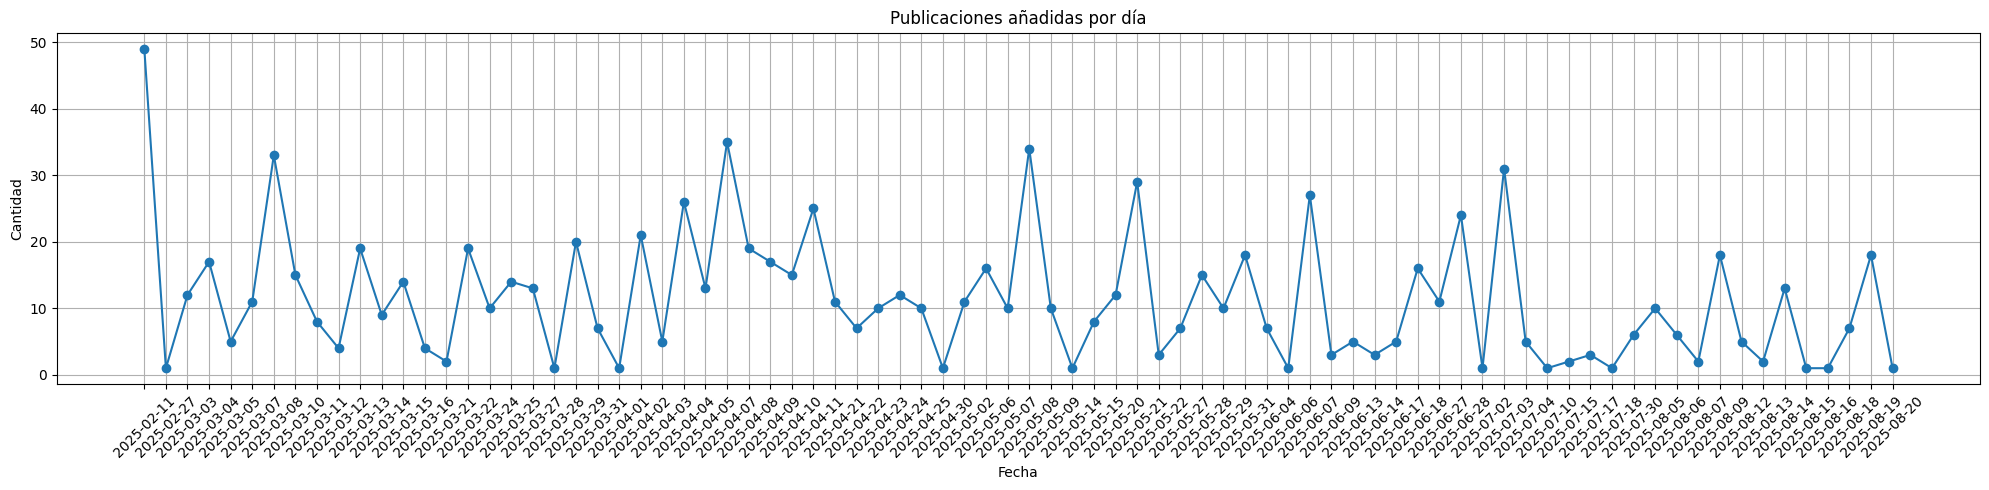

In [9]:
df = pd.DataFrame(items)
df["fecha"] = pd.to_datetime(df["fecha"])

# Agrupar por día
conteo_por_dia = df.groupby(df["fecha"].dt.date).size().reset_index(name="Total_Publicaciones")

# Opcional: convertir fechas a string para exportar
conteo_por_dia["fecha"] = conteo_por_dia["fecha"].astype(str)

# Generamos la grafica de publicaciones añadidas por día
plt.figure(figsize=(20, 5))
plt.plot(conteo_por_dia["fecha"], conteo_por_dia["Total_Publicaciones"], marker='o')
plt.xticks(rotation=45)
plt.title("Publicaciones añadidas por día")
plt.xlabel("Fecha")
plt.ylabel("Cantidad")
plt.tight_layout()
plt.grid(True)
plt.show()

Al agrupar las publicaciones por semana en lugar de por día, la gráfica se vuelve más limpia y comprensible. En la visualización diaria se generan muchos puntos dispersos, lo que puede hacer difícil identificar tendencias claras debido a la variabilidad natural (algunos días se agregan muchas referencias y otros ninguna).

En cambio, la vista semanal suaviza esas fluctuaciones y muestra con mayor claridad los periodos de mayor o menor productividad en la incorporación de referencias. Esto permite:

* Detectar picos semanales de trabajo en la recopilación bibliográfica.

* Observar de manera más estable la tendencia general en el tiempo.

* Comparar semanas entre sí para identificar patrones de actividad (por ejemplo, semanas intensivas de búsqueda vs. semanas más tranquilas).

La visualización por semana reduce el ruido del día a día y resalta las tendencias globales, facilitando el análisis de la evolución de tu biblioteca Zotero.

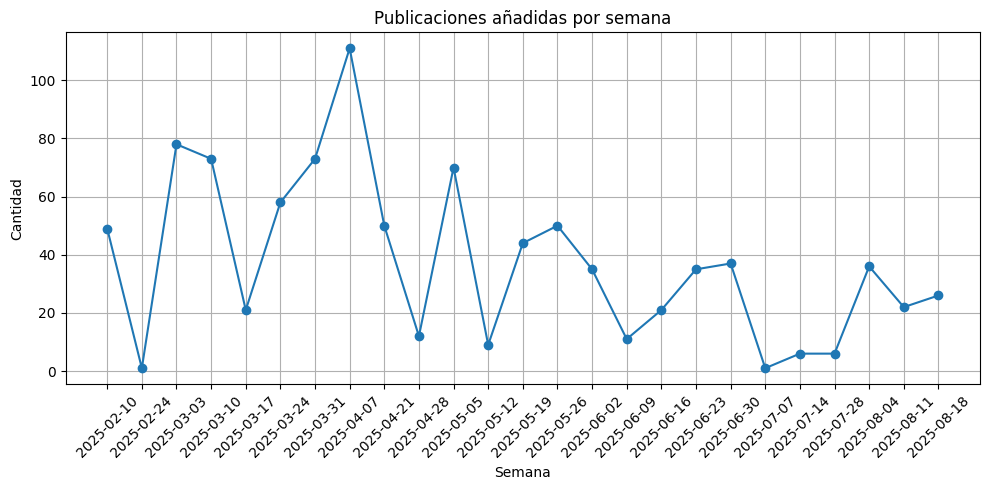

In [10]:
# 🔹 Agrupar por semana (esto crea objetos tipo "2025-08-04/2025-08-10")
df["fecha_sin_tz"] = df["fecha"].dt.tz_localize(None)
df["semana"] = df["fecha_sin_tz"].dt.to_period("W").apply(lambda r: r.start_time)

# 🔹 Contar publicaciones por semana
conteo_semanal = df.groupby("semana").size().reset_index(name="Total_Publicaciones")

# 🔹 Convertir fechas para graficar o exportar
conteo_semanal["semana"] = conteo_semanal["semana"].dt.strftime("%Y-%m-%d")

# Vemos la grafica a nivel semanal
plt.figure(figsize=(10, 5))
plt.plot(conteo_semanal["semana"], conteo_semanal["Total_Publicaciones"], marker='o')
plt.xticks(rotation=45)
plt.title("Publicaciones añadidas por semana")
plt.xlabel("Semana")
plt.ylabel("Cantidad")
plt.grid(True)
plt.tight_layout()
plt.show()

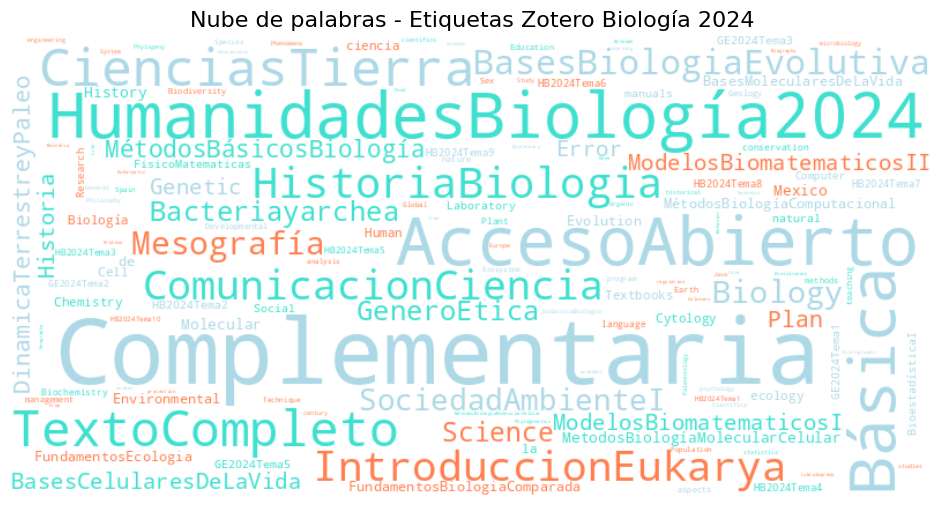

In [11]:
# Paleta personalizada: azul claro, azul turquesa, coral
palette = ['#ADD8E6', '#40E0D0', '#FF7F50']

def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(palette)

# Convertir todas las etiquetas en un solo string
text = ' '.join(all_tags)

# Crear la nube
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    color_func=color_func,
    collocations=False
).generate(text)

# Mostrar la nube
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nube de palabras - Etiquetas Zotero Biología 2024", fontsize=16)
plt.show()


Se realizo un análisis de los títulos de las referencias permitiendo garantizar la calidad y coherencia de la base bibliográfica. Dado que Zotero se usa frecuentemente para generar citas y bibliografías en documentos académicos, los errores en los títulos (como guiones mal colocados, uso incorrecto de mayúsculas, puntos innecesarios o faltas de ortografía) pueden trasladarse de forma automática a los artículos, tesis o reportes en los que se cite la fuente.

Este proceso de revisión y limpieza tiene varias ventajas:

* Coherencia formal: asegura que todos los títulos sigan el mismo estilo de escritura, evitando inconsistencias que afectan la presentación profesional del trabajo.

* Evitar errores en citas automáticas: al corregir la ortografía y el formato, se reducen fallos al exportar bibliografías en estilos como APA, MLA o Vancouver.

* Ahorro de tiempo: una biblioteca limpia significa menos correcciones manuales al final de un proyecto.

* Mayor credibilidad académica: las referencias son parte fundamental de cualquier investigación, y tener títulos bien escritos refleja rigurosidad y cuidado en el trabajo científico.

En síntesis, este análisis convierte la biblioteca de Zotero en una fuente depurada y confiable, lista para integrarse directamente en publicaciones sin arrastrar errores tipográficos o de estilo.

In [12]:
import pandas as pd
import re
from spellchecker import SpellChecker

# Cargamos tus datos (asegúrate de tener df['titulo'])
spell = SpellChecker(language='es')

# Lista para almacenar títulos con problemas
problemas = []

# Recorremos los títulos
for titulo in df["titulo"].dropna():
    errores = []

    # 1. Palabras en mayúsculas (completamente)
    if any(word.isupper() and len(word) > 1 for word in titulo.split()):
        errores.append("MAYÚSCULAS")

    # 2. Punto final
    if titulo.strip().endswith("."):
        errores.append("PUNTO FINAL")

    # 3. Espacios dobles
    if "  " in titulo:
        errores.append("ESPACIOS DOBLES")

    # 4. Guiones
    if "-" in titulo:
        errores.append("GUIONES")

    # 5. Corchetes
    if "[" in titulo or "]" in titulo:
        errores.append("CORCHETES")

    # 6. Símbolos especiales
    if re.search(r"[@#\$%\^&\*\~\=]", titulo):
        errores.append("SÍMBOLOS ESPECIALES")

    # 7. Faltas de ortografía
    palabras = re.findall(r'\b\w+\b', titulo.lower())
    errores_ort = spell.unknown(palabras)

    if errores_ort and len(errores_ort) >= 2:  # tolerancia: al menos 2 palabras mal
        errores.append("ORTOGRAFÍA")

    # Guardamos si hay al menos un error
    if errores:
        problemas.append({"titulo": titulo, "errores": ", ".join(errores)})

# Convertimos en DataFrame
df_errores = pd.DataFrame(problemas)
print(f"🔎 Títulos problemáticos encontrados: {len(df_errores)}")
df_errores.head(10)


🔎 Títulos problemáticos encontrados: 608


,titulo,errores
0,Los procesos alterados y los procesos transfor...,ORTOGRAFÍA
1,Cells: a laboratory manual,ORTOGRAFÍA
2,Engineering plants for agriculture: a subject ...,ORTOGRAFÍA
3,Synthetic biology: tools for engineering biolo...,ORTOGRAFÍA
4,Basic methods in protein purification and anal...,ORTOGRAFÍA
5,Proteomics: a Cold Spring Harbor Laboratory co...,ORTOGRAFÍA
6,PDF gratuito,MAYÚSCULAS
7,Protein Purification: An Overview,ORTOGRAFÍA
8,CRISPR/CAS-Mediated genome editing in plants,"GUIONES, ORTOGRAFÍA"
9,PDF gratuito,MAYÚSCULAS


✅ Total de ítems descargados: 935


/tmp/ipython-input-3459176126.py:53: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


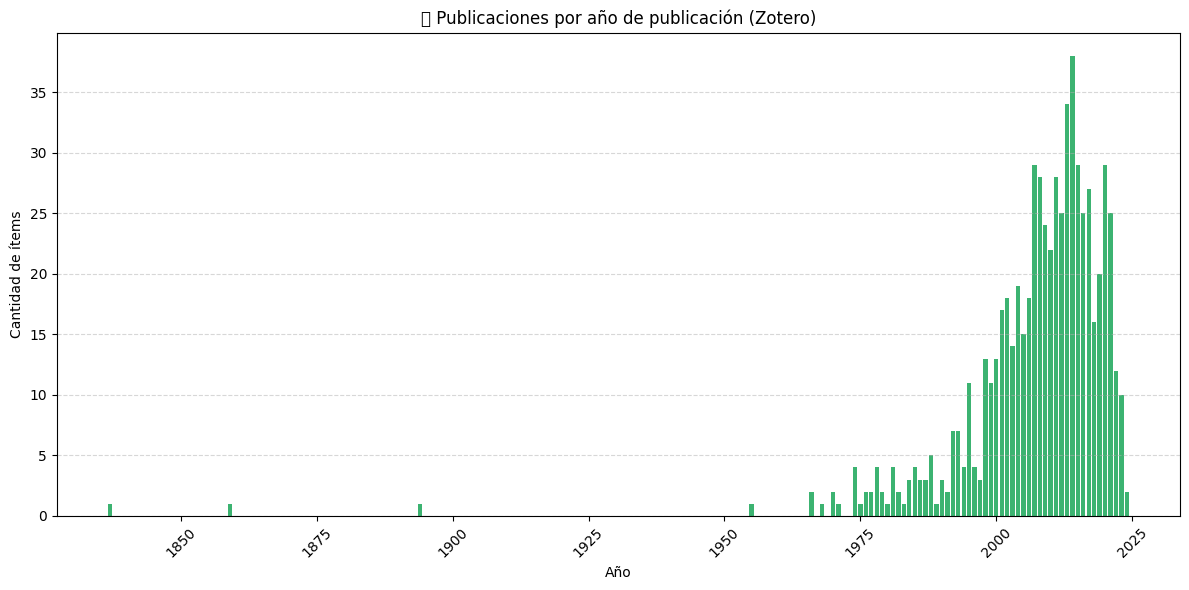

In [13]:
import requests
import pandas as pd
import re

items = []
start = 0
limit = 100

while True:
    url = f"https://api.zotero.org/groups/{GROUP_ID}/items?limit={limit}&start={start}"
    response = requests.get(url, headers=HEADERS)
    data = response.json()

    if not data:
        break

    for item in data:
        d = item["data"]
        date_raw = d.get("date", "")

        # Extraer año con regex (si existe un año de 4 dígitos)
        match = re.search(r"\b(1[89]\d{2}|20\d{2}|21\d{2})\b", date_raw)
        year = int(match.group(0)) if match else None

        items.append({
            "titulo": d.get("title"),
            "año": year,
            "tipo": d.get("itemType")
        })

    start += limit

# Crear DataFrame
df = pd.DataFrame(items)
print(f"✅ Total de ítems descargados: {len(df)}")
df.head()

conteo_por_anio = df["año"].value_counts().sort_index().reset_index()
conteo_por_anio.columns = ["Año", "Cantidad"]
conteo_por_anio = conteo_por_anio[conteo_por_anio["Año"].notnull()]  # Filtrar nulos
conteo_por_anio["Año"] = conteo_por_anio["Año"].astype(int)
conteo_por_anio

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(conteo_por_anio["Año"], conteo_por_anio["Cantidad"], color="mediumseagreen")
plt.title("📅 Publicaciones por año de publicación (Zotero)")
plt.xlabel("Año")
plt.ylabel("Cantidad de ítems")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




/tmp/ipython-input-1221327912.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_validos["edad"] = anio_actual - df_validos["año"]


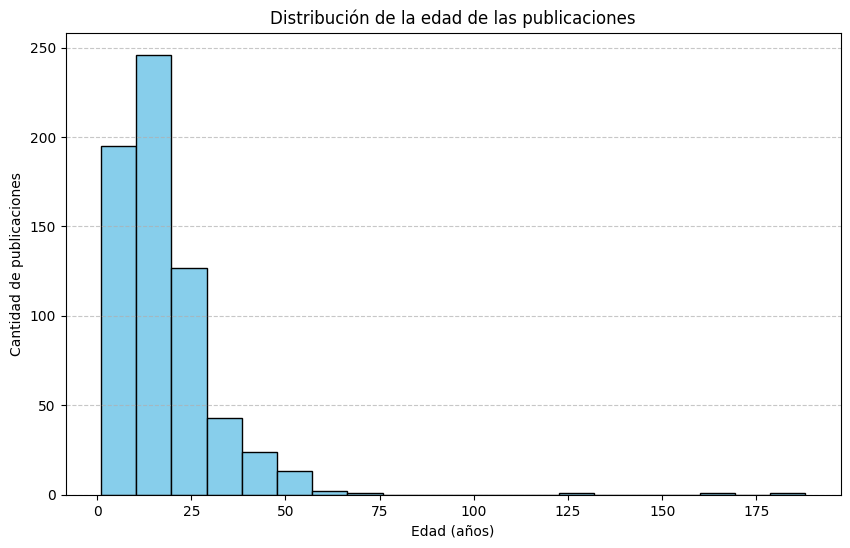

In [14]:
from datetime import datetime

anio_actual = datetime.now().year

# Filtramos filas con año válido
df_validos = df[df["año"].notnull()]

# Calculamos edad de cada publicación
df_validos["edad"] = anio_actual - df_validos["año"]

# Vemos los primeros
df_validos.head()

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(df_validos["edad"], bins=20, color="skyblue", edgecolor="black")
plt.title("Distribución de la edad de las publicaciones")
plt.xlabel("Edad (años)")
plt.ylabel("Cantidad de publicaciones")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [15]:
# Edad promedio de la libreria.
edad_promedio = df_validos["edad"].mean()
print(f"La edad promedio de las publicaciones es de {edad_promedio:.2f} años.")

La edad promedio de las publicaciones es de 17.80 años.
